In [11]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1)

from plotnine import (
    ggplot, aes, geom_line, scale_colour_manual,
    geom_abline, element_blank,
    facet_wrap, theme_bw, theme,
    coord_fixed, element_text
    )

In [12]:
task_names = ["fraziergaussian", "sirsde"]
pretty_task_name = {"fraziergaussian": "Gaussian", "sirsde": "SIR"}

methods = ["Robust NPE", "NPE"]

results = {t: [] for t in task_names}

for task in results.keys():
    results_dir = f"../results/{task}/"
    for f_name in sorted(os.listdir(results_dir)):
        if ".pickle" in f_name:
            with open(results_dir + f_name, "rb") as f:
                results[task].append(pickle.load(f)["metrics"])
            

In [13]:
df_list = []

for task in ["fraziergaussian", "sirsde"]:
    for method in methods:
        task_em_res = [res[method] for res in results[task]]
        metrics = {k: [res[k] for res in task_em_res] for k in ["log_prob_theta*", "hpd"]}
        metrics["Task"] = pretty_task_name[task]
        metrics["Method"] = method
        df_list.append(pd.DataFrame(metrics))

df = pd.concat(df_list)
df = df.reset_index(drop=True)


In [ ]:
# TODO Add true posterior log probs for Gaussian task

# sum_y = s_obs[0]*s_std[0]*x_dim
# likelihood_std = 2  # for p(theta|y)
# prior_std = 5
# mu = (sum_y/likelihood_std**2) * (1/prior_std**2 + x_dim/likelihood_std**2)**(-1)
# std = jnp.sqrt((1/prior_std**2 + x_dim/likelihood_std**2)**(-1))
# mu = (mu - theta_mean) / theta_std
# std = std / theta_std

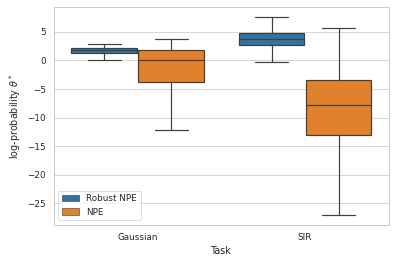

In [16]:
p = sns.boxplot(
    x = "Task",
    y = "log_prob_theta*",
    hue = "Method",
    showfliers=False,
    data=df)
plt.ylabel(r"log-probability $\theta^*$")
handles, labels = p.get_legend_handles_labels() # Remove legend title
p.legend(handles=handles, labels=labels, loc = "lower left")

plt.savefig("../results/plots/log_prob_theta_true.png", bbox_inches="tight", dpi=300)

## Coverage plot

In [17]:
import numpy as np

confidence_level = np.linspace(0, 1, 501)

cov_df_list = []
for task in pretty_task_name.values():
    for method in methods:
        coverage = []
        for level in confidence_level:
            hpd_subset = df["hpd"][(df["Task"] == task) & (df["Method"] == method)]
            coverage.append(sum(hpd_subset/100 <= level)/len(hpd_subset))
        

        cov_df_list.append(
            pd.DataFrame({
                "Confidence Level": confidence_level,
                "Empirical Coverage": coverage,
                "Task": task,
                "Method": method
            })
        )
cov_df = pd.concat(cov_df_list)
cov_df = cov_df.reset_index(drop=True)


/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 6 in image.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../results/plots/coverage.png
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-package

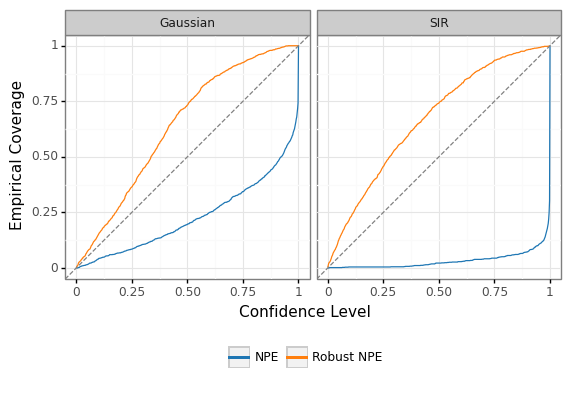

<ggplot: (8759638064586)>

In [61]:

p = (
    ggplot(aes(x="Confidence Level", y="Empirical Coverage", colour="Method"), data=cov_df) +
    facet_wrap("~Task", nrow=1) +
    geom_line() +
    scale_colour_manual(values=["tab:blue", "tab:orange"]) +
    geom_abline(slope=1, intercept=0, linetype="dashed", color="grey") +
    theme_bw() +
    coord_fixed() +
    theme(
        legend_title=element_blank(),
        legend_position="bottom",
        legend_box_spacing=.5,
        strip_text_x = element_text(margin={'t': 10, 'b': 8})
        )
)
p.save("../results/plots/coverage.png", dpi=300, width=8, height=6, units="in")
p


In [ ]:
# Alternative visualisation
# (ggplot(aes(x="hpd", fill="Method"), data=df) +
# facet_wrap("~task", scales="free_y", ncol=1) +
# geom_histogram(alpha=0.6, position="identity", binwidth=5) +
# scale_fill_manual(values=["tab:blue", "tab:orange"]) +
# xlab("Smallest HPD% containing theta*") +
# theme_bw()
# )
